# Testing LTLf and DFA python packages

In [ ]:
import pylogics  # I don't actually think this is useful
from pythomata import SimpleDFA
from pythomata.impl.symbolic import SymbolicDFA
from pythomata.simulator import AutomatonSimulator
from ltlf2dfa.parser.ltlf import LTLfParser
import graphviz

(F((a & F((b & F(c))))) & G(!(u)))


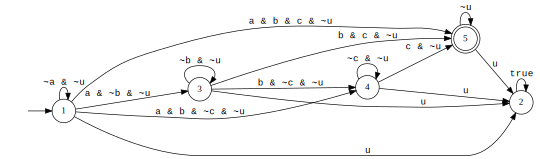

In [41]:
parser = LTLfParser()

# Sequential reachability problem (A -> B -> C while avoiding U), assuming that we can't enter multiple goals at the same time

# The issue with the 'simple' formula is that it doesn't understand that you cannot enter multiple goals at the same time
# It includes transitions for all possible cases of reaching more than one goal in the same time-step
# For modular Rl methods this is fine since the agent learns a policy for each state, not each transition
# However this isn't good for our purposes since it means the agent will try to learn a bunch of extra policies for impossible tasks
formula_str = "F (a & F (b & F (c ))) & G ~u"
formula = parser(formula_str)

print(formula)

dfa = formula.to_dfa()  # DFA as a string, in DOT format (suitable for Graphviz)
dfa_viz = graphviz.Source(dfa, format="png")
dfa_viz

(F(((a & !(b) & !(c)) & F(((!(a) & b & !(c)) & F((!(a) & !(b) & c)))))) & G(!(u)))


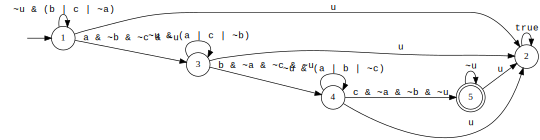

In [42]:
# If we make this explicit, we get a much cleaner graph that represents exactly all the realistic transitions
# However, in some problems it may be possible to reach multiple goals in the same time step (if they overlap)
# This highlights the necessity of embedding as much problem context into the LTLf formula as possible
# With this approach the required LTLf formula could quickly become convoluted and unwieldy
# Maybe we'd be able to just skip training impossible transitions at runtime? But we'd need a way to tell that they're impossible
formula_str = "F ((a & ~b & ~c) & F ((~a & b & ~c) & F ((~a & ~b & c)))) & G ~u"
formula = parser(formula_str)

print(formula)

dfa = formula.to_dfa()
dfa_viz = graphviz.Source(dfa, format="png")
dfa_viz

F((a & F(((b | c) & F(d)))))


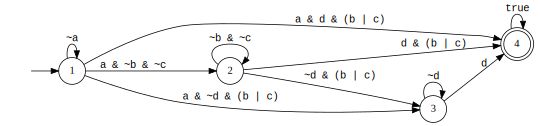

In [43]:
# Sequential reachability task where the agent can choose between two options (again assuming no overlap)
# Again, there's also impossible transitions since the DFA doesn't know that we can't reach multiple goals at the same time
# We somehow need to prune these without making the LTLf formula unnecessarily complicated
formula_str = "F (a & F((b | c) & F (d)))"
formula = parser(formula_str)

print(formula)

dfa = formula.to_dfa()
dfa_viz = graphviz.Source(dfa, format="png")
dfa_viz

In [44]:
# Unfortunately, the constructed DFA is a string in DOT format
# However, we want an actual DFA object (e.g. from pythomata, but I suppose we could use any FSM library)
print(dfa)

digraph MONA_DFA {
 rankdir = LR;
 center = true;
 size = "7.5,10.5";
 edge [fontname = Courier];
 node [height = .5, width = .5];
 node [shape = doublecircle]; 4;
 node [shape = circle]; 1;
 init [shape = plaintext, label = ""];
 init -> 1;
 1 -> 1 [label="~a"];
 1 -> 2 [label="a & ~b & ~c"];
 1 -> 3 [label="a & ~d & (b | c)"];
 1 -> 4 [label="a & d & (b | c)"];
 2 -> 2 [label="~b & ~c"];
 2 -> 3 [label="~d & (b | c)"];
 2 -> 4 [label="d & (b | c)"];
 3 -> 3 [label="~d"];
 3 -> 4 [label="d"];
 4 -> 4 [label="true"];
}


(a & !(b) & !(c))


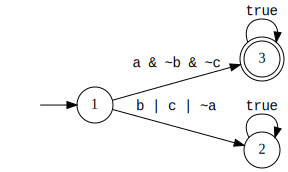

In [ ]:
# We can treat each transition as its own LTLf formula (and DFA)
# This LTLf formula enters the accepting state if the transition conditions are true and enters the sink state if false
formula_str = "a & ~b & ~c"
formula = parser(formula_str)

print(formula)

dfa = formula.to_dfa()
dfa_viz = graphviz.Source(dfa, format="png")
dfa_viz

In [ ]:
# Note that the pythomata SimpleDFA doesn't understand logic expressions for the transition conditions; each transition must be exactly a letter in the alphabet
# This is annoying, since ideally we want to be able to give our automaton the boolean value of each atomic proposition (and it decides what transition to make from that)
# I will probably need to create a wrapper that sorts all this out
states = {"1", "2"}
alphabet = {"a", "~a", "true"}
initial_state = "1"
accepting_states = {"2"}
transition_function = {
    "1": {
        "~a": "1",
        "a": "2",
    },
    "2": {
        "true": "2",
    },
}

automaton = SimpleDFA(
    states=states,
    alphabet=alphabet,
    initial_state=initial_state,
    accepting_states=accepting_states,
    transition_function=transition_function,
)

{'1', '2'}
1
{'2'}
{('2', 'true', '2'), ('1', 'a', '2'), ('1', '~a', '1')}


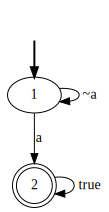

In [47]:
print(automaton.states)
print(automaton.initial_state)
print(automaton.accepting_states)
print(automaton.get_transitions())

automaton_viz = automaton.to_graphviz()
automaton_viz

In [ ]:
simulator = AutomatonSimulator(automaton)
print(
    simulator.is_started
)  # bool for whether automaton has started (implemented as a variable, for some reason)
print(simulator.cur_state)  # current state (implemented as a variable, for some reason)
simulator.step("~a")  # step the automaton with a transition label
print(simulator.is_started)
print(
    simulator.is_failed()
)  # check failure (broken transition logic, not unacceptance)
simulator.step("a")
print(simulator.is_true())
simulator.step("true")
print(simulator.is_failed())
simulator.step("a")
print(simulator.is_failed())  # invalid transition for the current state causes failure
simulator.reset()  # resets the automaton
print(simulator.cur_state)
print(simulator.is_failed())

False
{'1'}
True
False
True
False
True
{'1'}
False


{0}
0
set()
{0, 1}
0
{1}


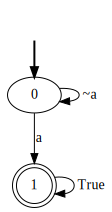

In [93]:
# The symbolic DFA understands propositional logic expressions by parsing the transition guard through sympy
automaton = SymbolicDFA()
print(automaton.states)
print(automaton.initial_state)
print(automaton.accepting_states)
automaton.create_state()
automaton.set_initial_state(0)
automaton.set_accepting_state(1, is_accepting=True)
print(automaton.states)
print(automaton.initial_state)
print(automaton.accepting_states)
automaton.add_transition((0, "~a", 0))
automaton.add_transition((0, "a", 1))
automaton.add_transition((1, "true", 1))

automaton_viz = automaton.to_graphviz()
automaton_viz

In [125]:
simulator = AutomatonSimulator(automaton)
print(
    simulator.is_started
)  # bool for whether automaton has started (implemented as a variable, for some reason)
print(simulator.cur_state)  # current state (implemented as a variable, for some reason)
simulator.step({"a": False})  # step the automaton with a transition label
print(simulator.cur_state)  # current state (implemented as a variable, for some reason)
print(simulator.is_started)
print(
    simulator.is_failed()
)  # check failure (broken transition logic, not unacceptance)
print(automaton.states)
available_transitions = automaton.get_transitions_from(
    next(iter(simulator.cur_state))
)  # note we have to extract the state from the set
for transition in available_transitions:
    print(transition)
simulator.step({"a": True})
print(simulator.cur_state)  # current state (implemented as a variable, for some reason)
print(simulator.is_true())
automaton.get_transitions_from(
    next(iter(simulator.cur_state))
)  # note we have to extract the state from the set
available_transitions = automaton.get_transitions_from(
    next(iter(simulator.cur_state))
)  # note we have to extract the state from the set
for transition in available_transitions:
    print(transition)
simulator.step({"a": True, "b": True})
print(simulator.cur_state)  # current state (implemented as a variable, for some reason)
print(simulator.is_failed())
simulator.step({"a": False})
print(simulator.cur_state)  # current state (implemented as a variable, for some reason)
print(simulator.is_failed())  # invalid transition for the current state causes failure
simulator.reset()  # resets the automaton
print(simulator.cur_state)
print(simulator.is_failed())
print(simulator.is_true())

False
{0}
{0}
True
False
{0, 1}
(0, ~a, 0)
(0, a, 1)
{1}
True
(1, True, 1)
{1}
False
{1}
False
{0}
False
False


In [ ]:
# We need to parse the string and construct a DFA from the extracted information
def construct_dfa_from_str(dfa_str: str):

    automaton = SimpleDFA(
        states=states,
        alphabet=alphabet,
        initial_state=initial_state,
        accepting_states=accepting_states,
        transition_function=transition_function,
    )
    return dfa